# url: https://www.learning-nao.com/?p=2620#q-q%E3%83%97%E3%83%AD%E3%83%83%E3%83%88

# 【統計】Pythonでt検定をやってみる

前回はt検定について、中身と流れをまとめました。

url: https://www.learning-nao.com/?p=2589

今回は、そのt検定をPythonでやってみようと思います。

## 使用するデータ
今回は定番のアイリスデータセットを使っていきます。

In [1]:
import pandas as pd
from sklearn.datasets import load_iris

iris = load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)

# さらに種類を追加します。iris.targetには種類が格納されており、0(=setosa), 1(=versicolor), 2(=virginica)の3値が入っています。
df['species'] = iris.target
display(df)

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),species
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [2]:
# 今回は2標本のt検定を実施するので、上のdfから2つの標本を作成します。
# species=0の標本と、species=1の標本を作成し、「petal width（cm）」で検定をします。

# この両標本は、「対応のないデータ」として扱います。

petal_len0 = df[df["species"]==0]["petal length (cm)"]
petal_len1 = df[df["species"]==1]["petal length (cm)"]

## 検定の前に

さて、早速t検定を…と行きたいところですが、その前にデータの特徴を確認しておきます。t検定には前提条件があるのでしたね。その前提とは

    母集団が正規分布に従う
    母集団の分散が等しい
    
です。この前提を満たし対応のない標本同士のt検定は「Studentのt検定」と呼ばれます。まずは、標本がこの前提を満たすかを確認します）。と言っても母分散はわからないので、標本の分散（標準偏差）と正規性あたりを確認します。



## 平均と標準偏差
各標本の平均と標準偏差を確認します。



In [3]:
#平均
print(petal_len0.mean())
print(petal_len1.mean())

#標準偏差
print(petal_len0.std())
print(petal_len1.std())

# 平均は3cm程度異なるようです。また、標準偏差も2.5倍くらい異なっていそうです。
# 標本数は同じのため母分散も等しくはなさそうです。

1.4620000000000002
4.26
0.17366399648018407
0.46991097723995795


## ヒストグラム
データのばらつきを見るために、それぞれの標本でヒストグラムを描いてみます。

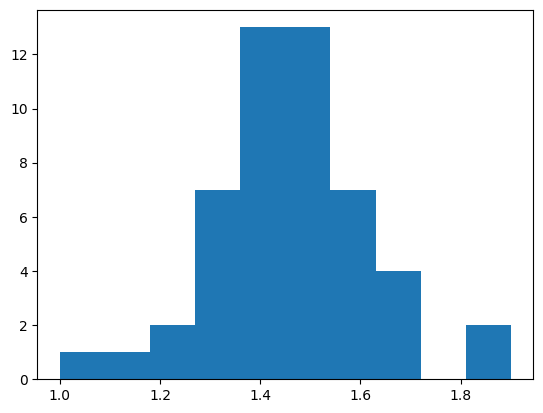

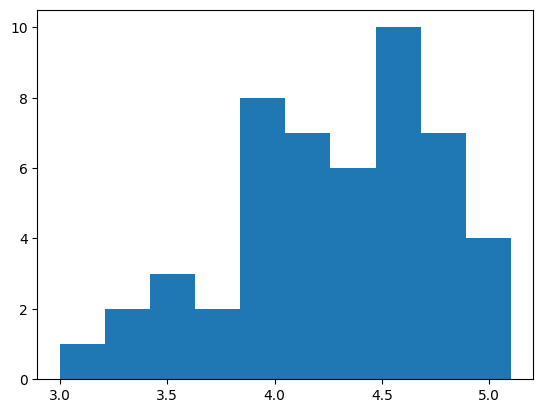

In [4]:
import matplotlib.pyplot as plt

plt.hist(petal_len0,bins=10)
plt.show()
plt.hist(petal_len1,bins=10)
plt.show()

# ほんまに正規分布に従ってるんか？って感じです。

## Q-Qプロット
グラフで正規性を確認する方法を紹介しました。としてQ-Qプロットも有効です。正規分布に近い場合、きれいな右肩上がりの直線になります。逆に、正規分布に従わない場合はその線が歪んで出てきます。

Q-Qプロットはscipyのstatsモジュールから描画可能です。

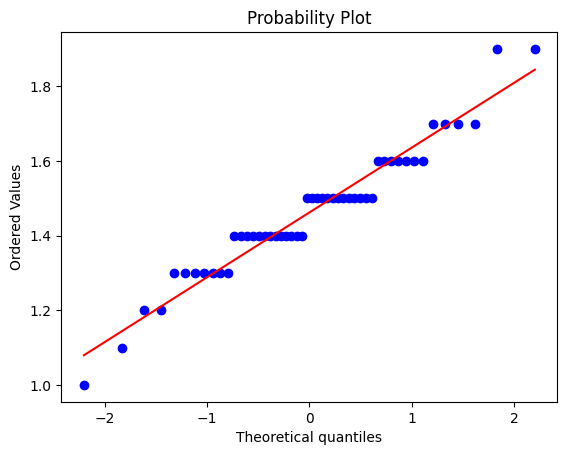

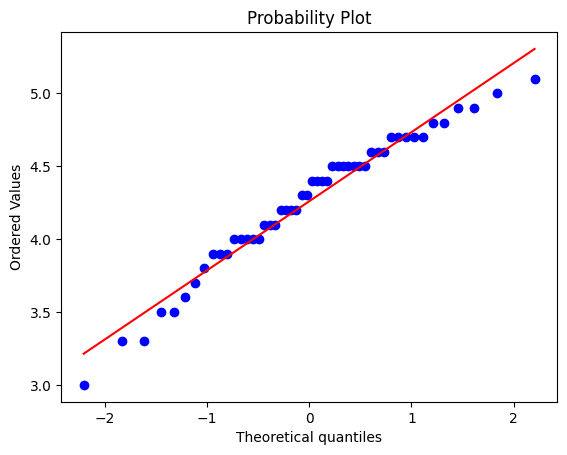

In [5]:
from scipy import stats

stats.probplot(petal_len0, plot=plt)
plt.show()

stats.probplot(petal_len1, plot=plt)
plt.show()

# どちらも端の方でやや歪んでいるように見えます。きれいな正規分布とはいえなさそうな気がします。

## シャピロ・ウィルク検定

シャピロ・ウィルク検定はデータの正規性を検定する手法の1つです。シャピロ・ウィルク検定の帰無仮説は「分布は正規分布に従う」です。今回は有意水準5%(p<=0.05)で検定を行ってみます。p値が0.05以下であれば分布は正規分布であるという帰無仮説が棄却されます。

この検定はscipyのstats.shapiro()で実行可能です。



In [6]:
from scipy import stats

#2つ目の戻り値がp値
p0 = stats.shapiro(petal_len0)[1]
p1 = stats.shapiro(petal_len1)[1]

print("sepal_len_0のp値：",round(p0,3))
print("sepal_len_1のp値：",round(p1,3))

# scipy.stats.shapiro()の引数には、検定したいデータを渡します。
# 検定結果はp値にて判断しますが、そのp値は2つ目の戻り値にて返されます（なので最後に[1]がついています）。

# 結果を見ると、両分布とも帰無仮説が採択されました（sepal_len_0はギリですが）。なので、一応正規分布に従うとして検定を進めていきます。

sepal_len_0のp値： 0.055
sepal_len_1のp値： 0.158


## t検定
ここまででデータの分散および正規性を確認しました。ここまでの前提をまとめると、

    対応のないデータ
    分散は等しくない
    正規分布に従う

です。この条件では「Welchのt検定」という手法を用います。Pythonでのt検定は、scipy.statsのttest()で行います。以下で実行してみましょう。

---

対応のないデータというのはデータ間に関連がないという認識でいいの?

はい、その通りです。対応のないデータとは、各観測値が互いに独立しているデータセットを指します。つまり、一方のデータポイントの値が他方のデータポイントに影響を与えていないと仮定されています。

例えば、異なる被験者や異なる条件での観測値などが、各データポイントに対応していない場合、それらのデータは対応のないデータと見なされます。これは通常、独立な2群間の比較（例: 独立なt検定）や、2つの変数の相関を評価する際に使用される前提条件です。

一方で、「対応のあるデータ」は、同じ対象や要素に関連する2つのデータセットを指し、各観測値が互いに依存していると考えられます。典型的な例は、同じ被験者に対する前後の測定値や、ペアで対応する要素がある場合です。

## Welchのt検定

先述の通り、Welchのt検定は等分散ではないと仮定した対応の無いt検定です。等分散でない場合は引数equal_varをFalseに指定します。

In [7]:
# Welchのｔ検定
stats.ttest_ind(petal_len0,petal_len1, equal_var=False)

# p値はpvalue（2つ目の引数）です。9.93で帰無仮説を棄却できないのかと思いがちですが、注意してください。
# e-46は小数点が右に46個ずれるという意味です。実際はかなり小さい値で、5%水準を軽く下回ります。

# よって、2つの標本平均に差がないとは言えないという結論に至りました。

TtestResult(statistic=-39.492719391538095, pvalue=9.934432957587695e-46, df=62.13976789553874)

## その他t検定
今回の場合、Welchのt検定を用いるのが適切でしたが、他の手法のt検定をPythonではどのように実行するのかも紹介しておきます。

## studentのt検定
この検定は対応なし、等分散の前提のもとで実施する検定です。

In [8]:
# studentのｔ検定
stats.ttest_ind(petal_len0,petal_len1)

TtestResult(statistic=-39.492719391538095, pvalue=5.404910513441677e-62, df=98.0)

## 対応のあるt検定
標本に対応がある場合は、scipy.stats.ttest_rel()を用います。

In [9]:
# 対応のあるｔ検定
stats.ttest_rel(petal_len0,petal_len1)

TtestResult(statistic=-37.2411259116569, pvalue=1.3246949994286691e-37, df=49)

# まとめ

Pythonでt検定を行う方法を紹介しました。

検定自体は1行で簡単にできますが、適切な手法を選ぶためにも、その前にデータの特性を確認しておく必要はあると思います。

2標本の比較は実際の場面でもよくあるケースだと思うので、t検定を活用して根拠を持って判断ができるといいですね。

ではでは👋

